### Librerias

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import re
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

### Cargando las imagenes de las diferentes categorias

In [2]:
%%time
#Lista de categorías
directorio = os.path.join(os.getcwd(), "F:/sonidos aves/data_sliding_short")
categorias = os.listdir(directorio)

#Listas de imagenes y etiquetas del modelo
imagenes = []
etiquetas = []

#Construcción de las listas
for i in range(len(categorias)):
    cat = os.listdir(directorio+"/"+categorias[i])
    for j in range(len(cat)):
        img = cv2.imread(directorio+"/"+categorias[i]+"/"+cat[j])
        #resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.equalizeHist(gray)
        imagenes.append(hist)
        etiquetas.append(categorias.index(categorias[i]))
    print("Imagenes de la categoria " + categorias[i] + " cargadas!")
        
#Listas convertidas en variables
X = np.array(imagenes, dtype=np.uint8)         
y = np.array(etiquetas)

Imagenes de la categoria Ammodramus humeralis_Grassland Sparrow cargadas!
Imagenes de la categoria Ara severus_Chestnut-fronted Macaw cargadas!
Imagenes de la categoria Aramus guarauna_Limpkin cargadas!
Imagenes de la categoria Bubo virginianus_Great Horned Owl cargadas!
Imagenes de la categoria Bubulcus ibis_Cattle Egret cargadas!
Imagenes de la categoria Buteo nitidus_Gray-lined Hawk cargadas!
Imagenes de la categoria Buteo platypterus_Broad-winged Hawk cargadas!
Imagenes de la categoria Campephilus melanoleucos_Crimson-crested Woodpecker cargadas!
Imagenes de la categoria Camptostoma obsoletum_Southern Beardless-Tyrannulet cargadas!
Imagenes de la categoria Catharus ustulatus_Swainson_s Thrush cargadas!
Imagenes de la categoria Chloroceryle amazona_Amazon Kingfisher cargadas!
Imagenes de la categoria Chlorophonia cyanea_Blue-naped Chlorophonia cargadas!
Imagenes de la categoria Chondrohierax uncinatus_Hook-billed Kite cargadas!
Imagenes de la categoria Chordeiles minor_Common Nighth

### Selección de los conjuntos de entrenamiento y prueba

In [3]:
%%time
Xtrain, Xtest, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=322)
print(Xtrain.shape)
print(Xtest.shape)

(55009, 224, 224)
(13753, 224, 224)
Wall time: 730 ms


### Preprocesamiento de las imagenes

In [4]:
%%time
num_classes = 173
input_shape = (224, 224, 1)

#normalizando los datos
train_scaled =np.zeros(Xtrain.shape[:3], dtype= "float32")
for i in range(Xtrain.shape[0]):
    train_scaled[i]=Xtrain[i]/255
    
test_scaled =np.zeros(Xtest.shape[:3], dtype= "float32")
for i in range(Xtest.shape[0]):
    test_scaled[i]=Xtest[i]/255
    
#Redimensionando
X_train = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[1], train_scaled.shape[2], 1)
X_test = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[1], test_scaled.shape[2], 1)
print(X_train.shape)
print(X_test.shape)

#Redimensionando vectores
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
print(y_train.shape)
print(y_test.shape)

(55009, 224, 224, 1)
(13753, 224, 224, 1)
(55009, 1)
(13753, 1)
Wall time: 9.31 s


### Configuracion de hiperparametros

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 60
image_size = 224  # We'll resize input images to this size
patch_size = 112  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 64
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [5000, 5000]  # Size of the dense layers of the final classifier

### Implementacion del perceptron multicapa

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Implementar la creación de parches como una capa

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Parches de una imagen de muestra

Image size: 224 X 224
Patch size: 112 X 112
Patches per image: 4
Elements per patch: 12544


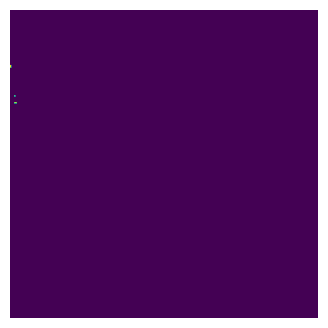

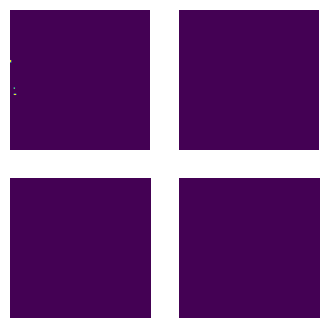

In [8]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Implementar la capa de codificación de parches

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Construya el modelo ViT

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 patches_1 (Patches)            (None, None, 12544)  0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 4, 64)        803136      ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 4, 64)       128         ['patch_encoder[0][0]']      

 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 4, 64)        0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 4, 64)       128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 4, 128)       8320        ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_6

 dropout_13 (Dropout)           (None, 4, 64)        0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 4, 64)        0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 4, 64)       128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 4, 64)       1060928     ['layer_normalization_14[0][0]', 
 eadAttention)                                                    'layer_normalization_14[0][0]'] 
          

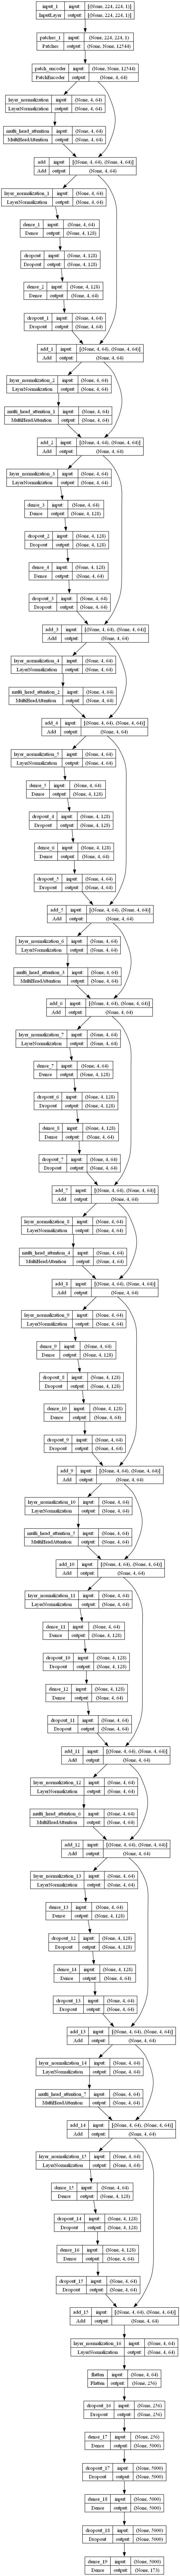

In [10]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

modelo = create_vit_classifier()
print(modelo.summary())
keras.utils.plot_model(modelo, show_shapes=True)

### Compilar, entrenar y evaluar el modelo

Epoch 1/60
387/387 [==============================] - 319s 804ms/step - loss: 3.9814 - accuracy: 0.1119 - val_loss: 3.4265 - val_accuracy: 0.1867
Epoch 2/60
387/387 [==============================] - 290s 750ms/step - loss: 3.4145 - accuracy: 0.2017 - val_loss: 3.0617 - val_accuracy: 0.2714
Epoch 3/60
387/387 [==============================] - 300s 776ms/step - loss: 3.1917 - accuracy: 0.2412 - val_loss: 2.8168 - val_accuracy: 0.3307
Epoch 4/60
387/387 [==============================] - 299s 772ms/step - loss: 2.9925 - accuracy: 0.2820 - val_loss: 2.6608 - val_accuracy: 0.3552
Epoch 5/60
387/387 [==============================] - 288s 743ms/step - loss: 2.8715 - accuracy: 0.3086 - val_loss: 2.5121 - val_accuracy: 0.3947
Epoch 6/60
387/387 [==============================] - 298s 770ms/step - loss: 2.7974 - accuracy: 0.3230 - val_loss: 2.4413 - val_accuracy: 0.4105
Epoch 7/60
387/387 [==============================] - 300s 775ms/step - loss: 2.6378 - accuracy: 0.3572 - val_loss: 2.3339 -

Epoch 57/60
387/387 [==============================] - 306s 792ms/step - loss: 1.4141 - accuracy: 0.6467 - val_loss: 1.6645 - val_accuracy: 0.6183
Epoch 58/60
387/387 [==============================] - 308s 795ms/step - loss: 1.4072 - accuracy: 0.6483 - val_loss: 1.6626 - val_accuracy: 0.6157
Epoch 59/60
387/387 [==============================] - 306s 792ms/step - loss: 1.3915 - accuracy: 0.6527 - val_loss: 1.6543 - val_accuracy: 0.6166
Epoch 60/60
387/387 [==============================] - 308s 797ms/step - loss: 1.4017 - accuracy: 0.6507 - val_loss: 1.6803 - val_accuracy: 0.6043


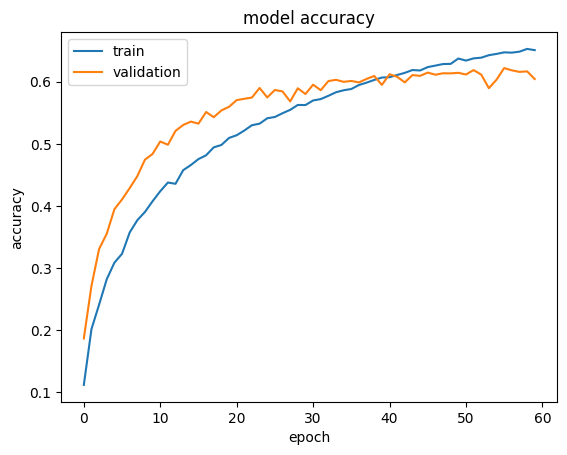

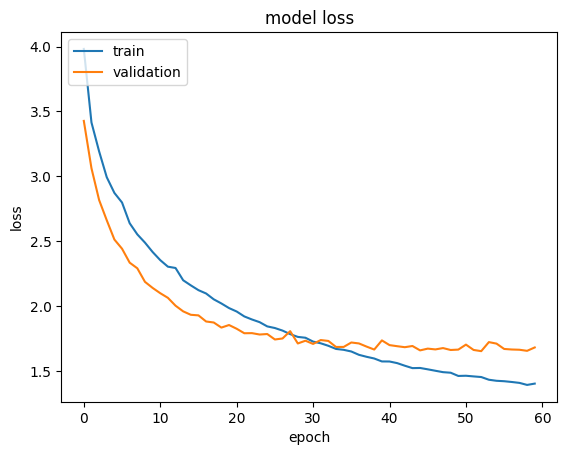

In [11]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer=optimizer,loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

    checkpoint_filepath = "F:/sonidos aves/definitivos/conv_completo/checkpoint.h5"
    checkpoint = ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only =True)
    
    earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20, 
                          verbose = 1,
                          restore_best_weights = True)
    
    callbacks_list = [
    checkpoint,
    earlystop,
    ]

    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_split=0.1,
                        verbose = 1,
                        callbacks=callbacks_list)


    ##Resumen de la precisión del modelo
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('F:/sonidos aves/definitivos/conv_completo/train_accuracy.png')
    plt.show()

    ##Resumen de la función de perdida
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('F:/sonidos aves/definitivos/conv_completo/train_loss.png')
    plt.show()

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

### Evaluación del conjunto de prueba

In [13]:
score = vit_classifier.evaluate(X_test, y_test, verbose = 1)
print("Conjunto de prueba. Función de perdida: ", score[0])
print("conjunto de prueba. Precisión: ", score[1])

430/430 [==============================] - 31s 71ms/step - loss: 1.6605 - accuracy: 0.6089
Conjunto de prueba. Función de perdida:  1.660460114479065
conjunto de prueba. Precisión:  0.6088853478431702


### Matriz de confusión

In [21]:
y_pred = vit_classifier.predict(X_test)
reporte = classification_report(np.argmax(y_pred, axis=1), y_test)
print(reporte)
c = confusion_matrix(np.argmax(y_pred, axis=1), y_test)
df = pd.DataFrame(c, index = categorias, columns = categorias)
df.to_excel('F:/sonidos aves/definitivos/conv_completo/confusion.xlsx', index = False)

430/430 [==============================] - 30s 69ms/step
              precision    recall  f1-score   support

           0       0.49      0.62      0.55       104
           1       0.61      0.70      0.65       159
           2       0.50      0.78      0.61        81
           3       0.37      0.74      0.49        43
           4       0.69      0.76      0.73       340
           5       0.48      0.66      0.55        70
           6       0.63      0.82      0.71        61
           7       0.71      0.66      0.68       270
           8       0.54      0.70      0.61        66
           9       0.40      0.84      0.54        44
          10       0.53      0.54      0.53        72
          11       0.47      0.80      0.59        55
          12       0.59      0.83      0.69        12
          13       0.40      0.52      0.45       181
          14       0.70      0.86      0.77       220
          15       0.84      0.08      0.15      2704
          16       0.81 

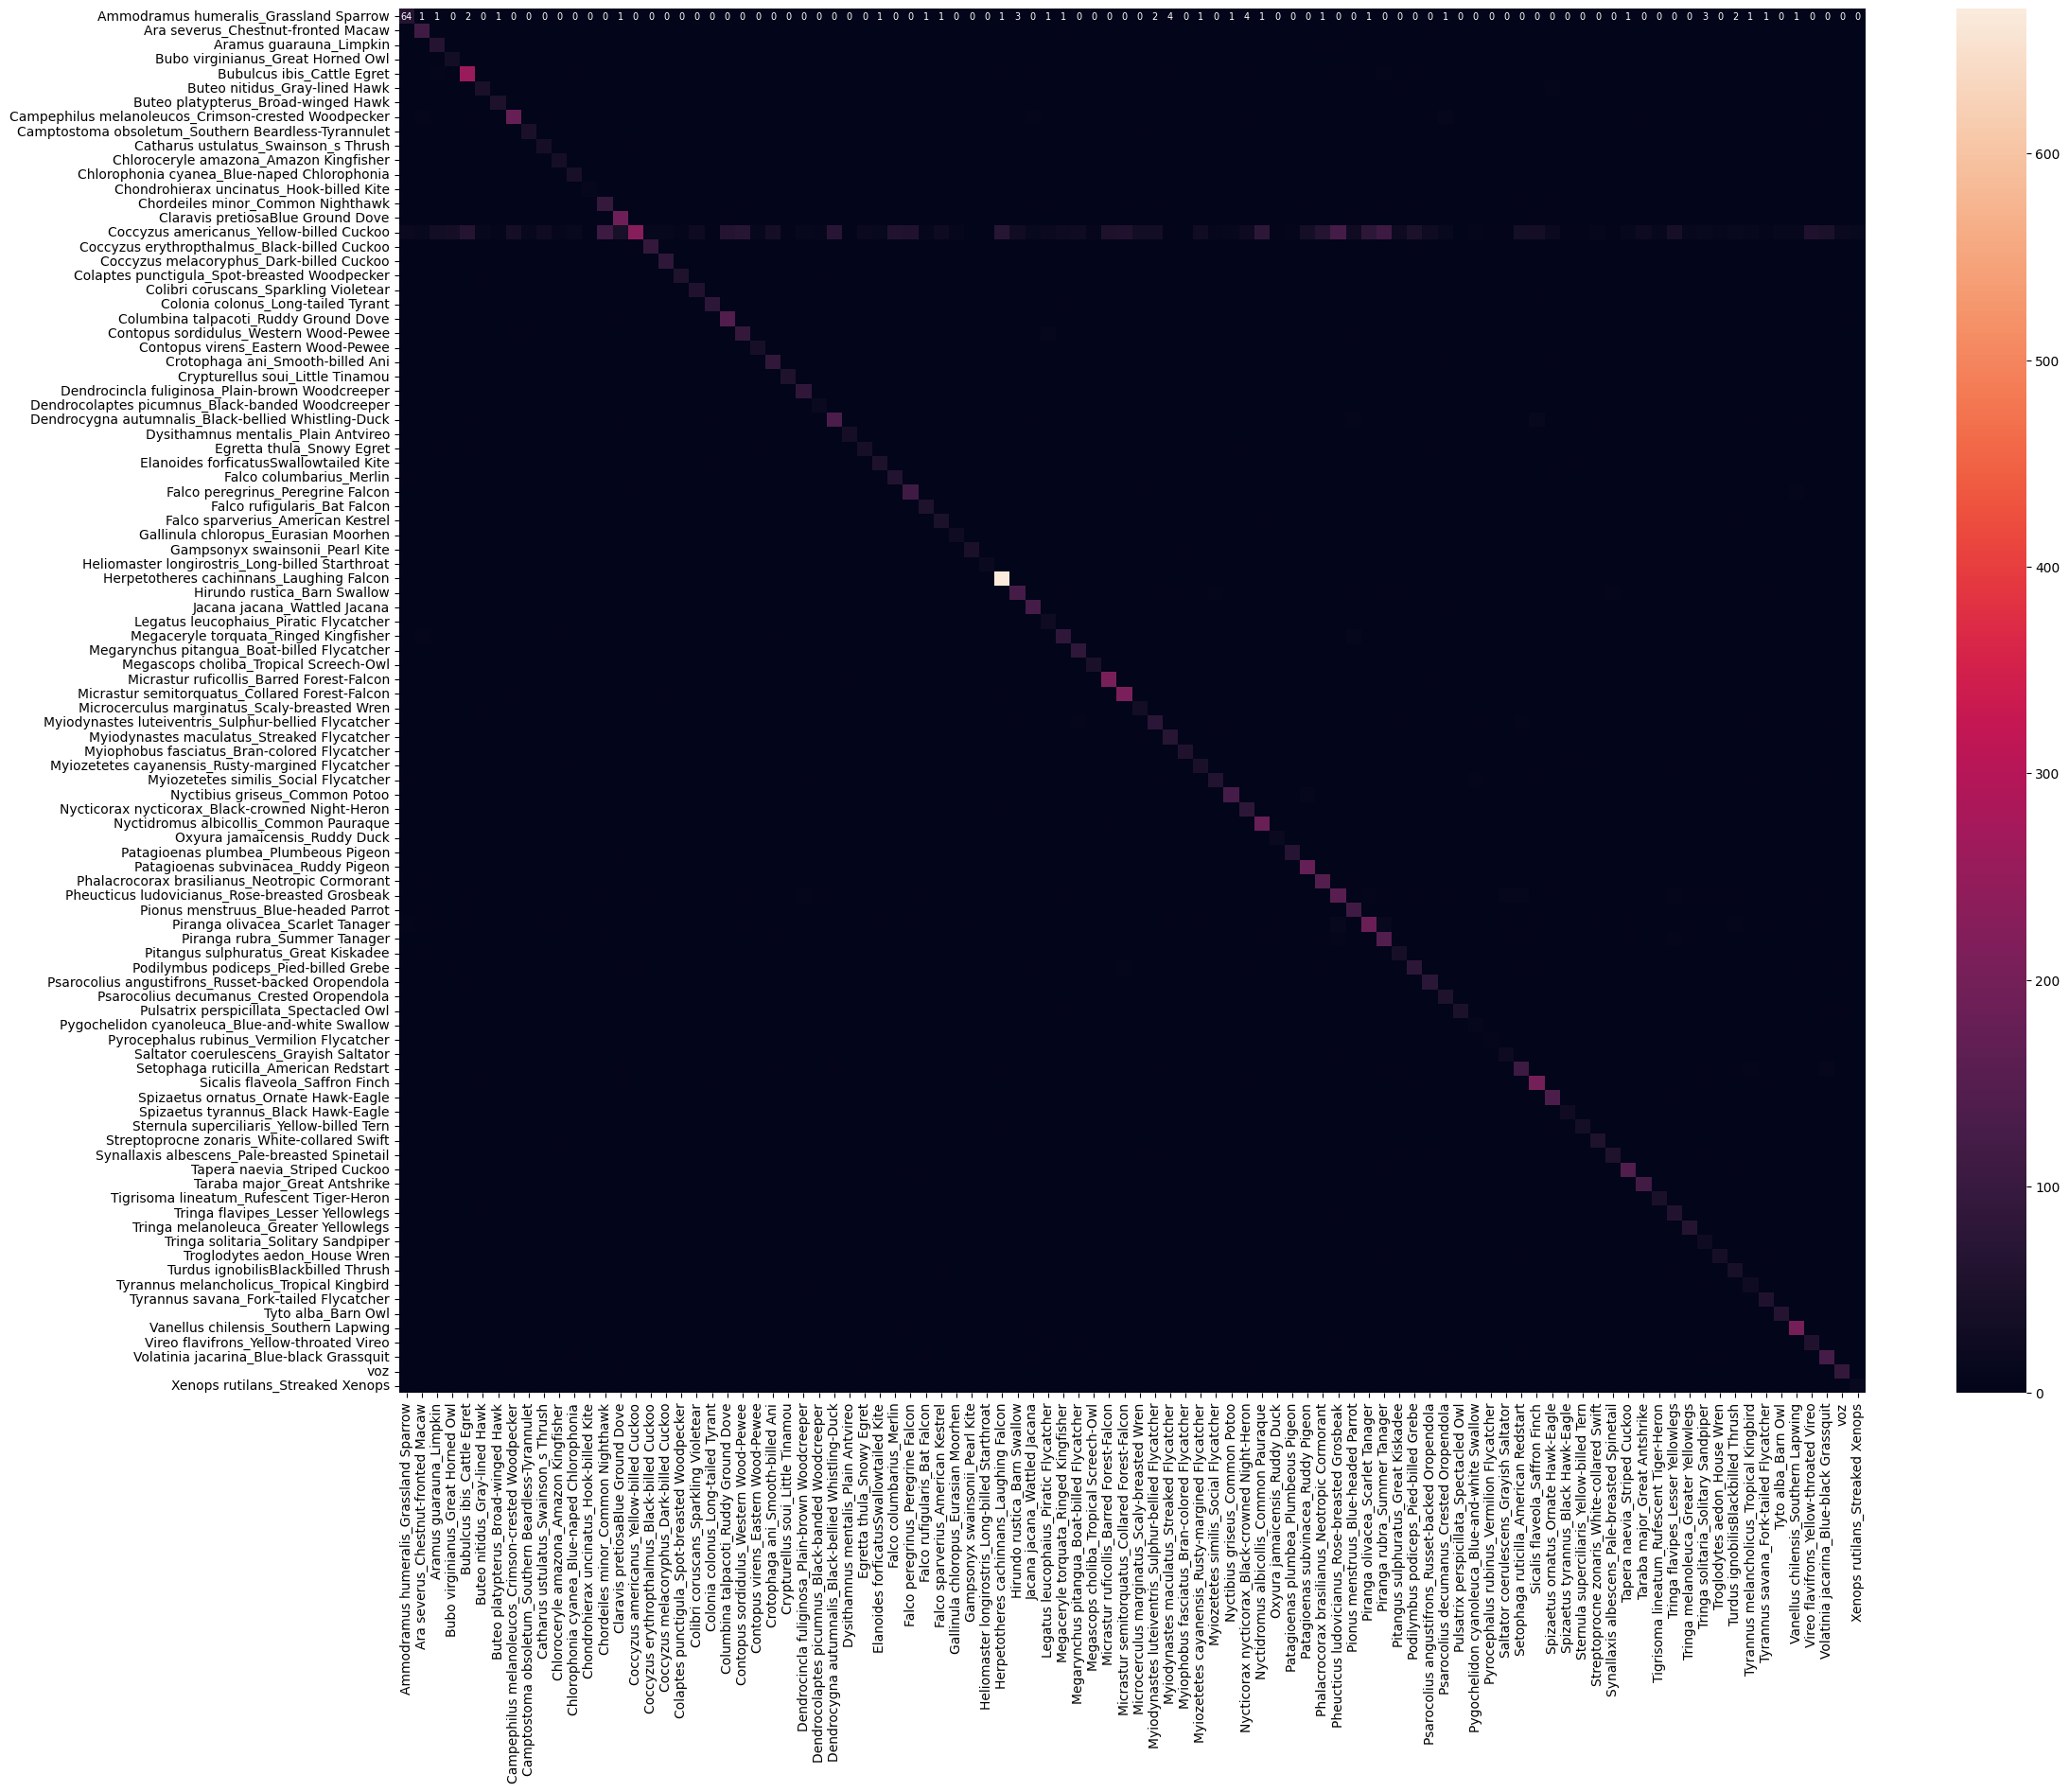

In [22]:
plt.figure(figsize = (25,19))
sns.heatmap(df, annot=True,annot_kws={"size": 7})
plt.savefig('F:/sonidos aves/definitivos/conv_completo/confusion.png')
plt.show()

### guardando el dataset con las clases etiquetadas

In [25]:
report_data = []
lines = reporte.split('\n')
for line in lines[2:]:
    row = {}
    row_data = re.split(r'\s{2,}', line.strip())
    if len(row_data) != 5:
        continue
    row['class'] = row_data[0]
    row['precision'] = float(row_data[1])
    row['recall'] = float(row_data[2])
    row['f1_score'] = float(row_data[3])
    row['support'] = float(row_data[4])
    report_data.append(row)
dataframe = pd.DataFrame.from_dict(report_data)
for i in range(len(categorias)):
    dataframe["class"][i] = categorias[i]
dataframe.to_excel('F:/sonidos aves/definitivos/conv_completo/classification_report.xlsx', index = False)
dataframe

,class,precision,recall,f1_score,support
0,Ammodramus humeralis_Grassland Sparrow,0.49,0.62,0.55,104.0
1,Ara severus_Chestnut-fronted Macaw,0.61,0.70,0.65,159.0
2,Aramus guarauna_Limpkin,0.50,0.78,0.61,81.0
3,Bubo virginianus_Great Horned Owl,0.37,0.74,0.49,43.0
4,Bubulcus ibis_Cattle Egret,0.69,0.76,0.73,340.0
...,...,...,...,...,...
93,Volatinia jacarina_Blue-black Grassquit,0.55,0.61,0.58,197.0
94,voz,0.61,0.70,0.65,127.0
95,Xenops rutilans_Streaked Xenops,0.33,0.75,0.45,20.0
96,macro avg,0.58,0.73,0.63,13753.0
